# Getting Started with Symbolics.jl

## Contents

- [Building Symbolic Expressions](#building_symbolic_expressions)
- [Derivatives](#derivatives)
- [Simplification and Substitution](#simplification_and_substitution)
- [Syms and callable Syms](#syms_and_callable_syms)
- [Building Functions](#building_functions)

## Building Symbolic Expressions <a id="building_symbolic_expressions" />

The way to define symbolic variables is via the `@variables` macro:

In [94]:
using Symbolics

@variables x y

2-element Vector{Num}:
 x
 y

After defining variables as symbolic, symbolic expressions, which we call a `iscall` object, can be generated by utilizing Julia expressions. For example:

In [95]:
z = x^2 + y

y + x^2

To make an array of symbolic expressions, simply make an array of symbolic expressions:

In [96]:
A = [x^2 + y 0 2x
     0       0 2y
     y^2 + x 0 0]

3×3 Matrix{Num}:
 y + x^2  0  2x
       0  0  2y
 x + y^2  0   0

Normal Julia functions work on Symbolics expressions, so if we want to create the sparse version of `A` we would just call `sparse`:

In [97]:
using SparseArrays
spA = sparse(A)

3×3 SparseMatrixCSC{Num, Int64} with 4 stored entries:
 y + x^2  ⋅  2x
       ⋅  ⋅  2y
 x + y^2  ⋅   ⋅

## Derivatives <a id="derivatives" />

In Symbolics.jl, derivatives are represented lazily via operations, just like any other function. To build a differential operator, use `Differential` like:

In [98]:
@variables t
D = Differential(t)

Differential(t)

This is the differential operator $D=\frac{\partial}{\partial t}$. We can compose the differential operator by $*$, e.g., `Differential(t) * Differential(x)` or `Differential(t)^2`.

In [99]:
z = t + t^2
D(z)

Differential(t)(t + t^2)

In [100]:
# Use expand_derivatives() to compute the derivative
expand_derivatives(D(z))

1 + 2t

In [101]:
# Alternative
Symbolics.derivative(z, t)

1 + 2t

We also have simplified functions for multivariable calculus:

In [102]:
Symbolics.jacobian([x + x*y, x^2 + y], [x, y])

2×2 Matrix{Num}:
 1 + y  x
    2x  1

and similarly we can do Hessians, gradients, and define whatever other derivatives you want.

## Simplification and Substitution <a id="simplification_and_substitution" />

Symbolics interfaces with SymbolicUtils.jl to allow for simplifying symbolic expressions. This is done simply through the `simplify` command:

In [103]:
simplify(2x + 2y)

2(x + y)

This can be applied to arrays by using Julia's broadcast mechanism:

In [104]:
B = simplify.([t + t^2 + t + t^2  2t + 4t
               x + y + y + 2t     x^2 - x^2 + y^2])

2×2 Matrix{Num}:
   2(t + t^2)   6t
 2(t + y) + x  y^2

We can then use substitute to change values of an expression around:

In [105]:
simplify.(substitute.(B, (Dict(x => y^2),)))

2×2 Matrix{Num}:
     2(t + t^2)   6t
 2(t + y) + y^2  y^2

and we can use this to interactively evaluate expressions without generating and compiling Julia functions:

In [106]:
V = substitute.(B, (Dict(x => 2.0, y => 3.0, t => 4.0),))

2×2 Matrix{Num}:
 40.0  24.0
 16.0   9.0

In [107]:
Symbolics.value.(V)

2×2 Matrix{Float64}:
 40.0  24.0
 16.0   9.0

## Syms and callable Syms <a id="syms_and_callable_syms" />

In [108]:
@variables t x(t) y(t)

3-element Vector{Num}:
    t
 x(t)
 y(t)

`t` is of type `Sym{Real}`, but the name `x` refers to an object that represents the `Termx(t)`. The operation of this expression is itself the object `Sym{FnType{Tuple{Real}, Real}}(:x)`. The type `Sym{FnType{...}}` represents a callable object. In this case specifically, it's a function that takes 1 Real argument (noted by `Tuple{Real}`) and returns a `Real` result. You can call such a callable `Sym` with either a number or a symbolic expression of a permissible type.

This expression also defines `t` as an independent variable, while `x(t)` and `y(t)` are dependent variables. This is accounted for in differentiation:

In [109]:
z = x + y*t
expand_derivatives(D(z))

y(t) + Differential(t)(x(t)) + t*Differential(t)(y(t))

We can also define unrestricted functions:

In [18]:
@variables g(..)

z = g(x) + g(y)

g(y(t)) + g(x(t))

## Building Functions <a id="building_functions" />

The function for building functions from symbolic expressions is the aptly-named `build_function`. The first argument is the symbolic expression or the array of symbolic expressions to compile, and the trailing arguments are the arguments for the function. For example:

In [22]:
to_compute = [x^2 + y, y^2 + x]
f_expr = build_function(to_compute, [x, y]);

gives back two codes. The first is a function `f([x, y])` that computes and builds an output vector `[x^2 + y, y^2 + x]`. Because this tool was made to be used by all the cool kids writing fast Julia codes, it is specialized to Julia and supports features like StaticArrays. For example:

In [23]:
using StaticArrays
myf = eval(f_expr[1])
myf(SA[2.0, 3.0])

2-element SVector{2, Float64} with indices SOneTo(2):
  7.0
 11.0

The second function is an in-place non-allocating mutating function which mutates its first value. Thus, we'd use it like the following:

In [24]:
myf! = eval(f_expr[2])
out = zeros(2)
myf!(out, [2.0, 3.0])
out

2-element Vector{Float64}:
  7.0
 11.0

## Series Expansion <a id="series_expansion" />

General:

$$ P(x) = f(a) + \frac{df}{dx}(a) \frac{(x-a)^1}{1!} + \frac{d^2f}{dx^2}(a) \frac{(x-a)^2}{2!} + ... $$

In [92]:
function expand_taylor(f, x, x0, order=4)

    P = substitute(f, x => x0)

    for i in 1:order
        D = Differential(x)^i
        P += substitute(expand_derivatives(D(f)), x => x0) * (x - x0)^i/(factorial(i))
    end

    return P
end

expand_taylor (generic function with 2 methods)

In [ ]:
@variables x
f = cos(x)
x0 = 0
expand_taylor(f, x, x0)

1.0 - 0.5(x^2) + (1//24)*(x^4)

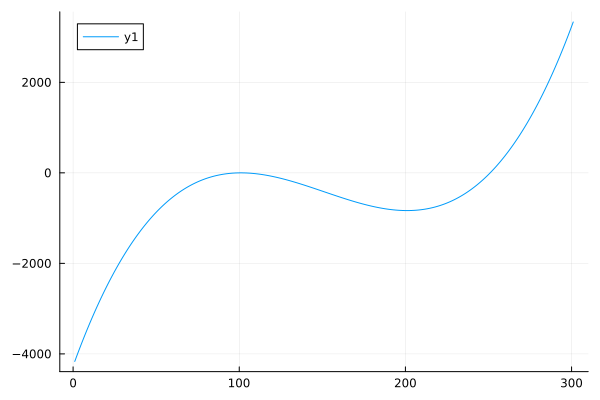

In [66]:
using Plots

r = 0.5
K = 100
F(N) = -r*0.5*N^2 + r/K * 1/3 * N^3

N_vec = -100:1:200
plot(F.(N_vec))